In [1]:
import os
import feedparser
import requests
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Etape 1 : Extraction des flux RSS

In [2]:
def extract_rss_entries():
    urls = [
        "https://www.cert.ssi.gouv.fr/avis/feed",
        "https://www.cert.ssi.gouv.fr/alerte/feed"
    ]
    entries = []
    for url in urls:
        feed = feedparser.parse(url)
        for entry in feed.entries:
            entries.append({
                'id': entry.link.split("/")[-2],
                'title': entry.title,
                'link': entry.link,
                'type': "Alerte" if "alerte" in url else "Avis",
                'date': entry.published
            })
    return entries

In [3]:
rss_entries = extract_rss_entries()
print(f"Nombre d'entrées RSS : {len(rss_entries)}")
# print(rss_entries)

Nombre d'entrées RSS : 80


# Etape 2 : Extraction des CVE

In [4]:
def extract_cves_from_json(entry_link):
    try:
        json_url = entry_link + "/json/"
        response = requests.get(json_url)
        data = response.json() # fichier JSON complet de l'entrée RSS

        # Extraction des CVE reference dans la clé cves du dict data
        cve_refs = data.get("cves", [])

        # Attention, il s’agit d’une liste des dictionnaires avec name et url comme clés
        """print("CVE références :", cve_refs)
        print("Type de références", type(cve_refs))
        print("Type des éléments de la liste", type(cve_refs[0]))"""

        # Extraction des CVE avec une regex
        cve_pattern = r"CVE-\d{4}-\d{4,7}"
        cve_list = list(set(re.findall(cve_pattern, str(data))))
        """print("CVE trouvés :", cve_list)"""

        # Retourne la liste de CVE référence pour l'entrée RSS entrée en argument + le JSON complet de l'entrée RSS
        return cve_refs, data
    except:
        return [], {}


In [5]:
first_entry = rss_entries[0]
cve_refs, full_json = extract_cves_from_json(first_entry["link"])

# Etape 3 : Enrichissement des CVE

In [6]:
def enrich_cve(cve_id):
    mitre = {}
    epss_score = None

    # API CVE de Mitre
    try:
        mitre_url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        r = requests.get(mitre_url)
        mitre_data = r.json()

        # Extraire la description de la CVE
        description = mitre_data["containers"]["cna"]["descriptions"][0]["value"]
        mitre['description'] = description

        # Extraire le score et sévérité CVSS
        cvss_score = None
        base_severity = ""
        metrics = mitre_data["containers"]["cna"].get("metrics", [])
        for metric in metrics:
            cvss = metric.get("cvssV3_1") or metric.get("cvssV3_0")
            if cvss:
                cvss_score = cvss.get("baseScore")
                base_severity = cvss.get("baseSeverity")
                break

        mitre['cvss_score'] = cvss_score
        mitre['base_severity'] = base_severity

        # Extraire le CWE (type de vulnérabilité)
        cwe = "Non disponible"
        cwe_desc = "Non disponible"
        problemtype = mitre_data["containers"]["cna"].get("problemTypes", {})
        if problemtype and "descriptions" in problemtype[0]:
            cwe = problemtype[0]["descriptions"][0].get("cweId", "Non disponible")
            cwe_desc=problemtype[0]["descriptions"][0].get("description", "Non disponible")

        mitre['cwe'] = cwe
        mitre['cwe_desc'] = cwe_desc

        # Extraire les produits affectés
        affected = mitre_data["containers"]["cna"]["affected"]
        for product in affected:
            vendor = product["vendor"]
            product_name = product["product"]
            versions = [v["version"] for v in product["versions"] if v["status"] == "affected"]
            mitre['vendor'] = vendor
            mitre['product'] = product_name
            # mitre['versions'] = ", ".join(versions)
            mitre['versions'] = versions

        """print(f"CVE : {cve_id}")
        print(f"Description : {description}")
        print(f"Score CVSS : {cvss_score}")
        print(f"Type CWE : {cwe}")
        print(f"CWE Description : {cwe_desc}")"""
    except Exception as e:
        print(f"Erreur lors de l'enrichissement de {cve_id} : {e}")
        pass

    # API EPSS de First
    try:
        epss_url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        r = requests.get(epss_url)
        epss_json = r.json()

        # Extraire la liste data du JSON (contenant le score EPSS)
        epss_data = epss_json.get("data", [])

        # Si la liste n'est pas vide, extraire le score EPSS
        if epss_data:
            epss_score = epss_data[0]["epss"]
            """print(f"CVE : {cve_id}")
            print(f"Score EPSS : {epss_score}")"""

        # Sinon, signaler le manque de score EPSS
        else:
            print(f"Aucun score EPSS trouvé pour {cve_id}")
    except Exception as e:
        print(f"Erreur lors de l'enrichissement de {cve_id} : {e}")
        epss_score = None

    return mitre, epss_score

In [7]:
cve_id_test = "CVE-2024-22024"
mitre_test, epss_score_test = enrich_cve(cve_id_test)
print("Données extraites de l'API Mitre :", mitre_test)
print("Score EPSS : " + epss_score_test)

Données extraites de l'API Mitre : {'description': 'An XML external entity or XXE vulnerability in the SAML component of Ivanti Connect Secure (9.x, 22.x), Ivanti Policy Secure (9.x, 22.x) and ZTA gateways which allows an attacker to access certain restricted resources without authentication.', 'cvss_score': 8.3, 'base_severity': 'HIGH', 'cwe': 'Non disponible', 'cwe_desc': 'Non disponible', 'vendor': 'Ivanti', 'product': 'IPS', 'versions': ['9.1R18.4', '9.1R17.3', '22.5R1.2']}
Score EPSS : 0.943200000


# Etape 4 : Consolidation des données

In [8]:
def process_entries(entries, limit=None):
    all_rows = []

    # Limiter la liste d'entrés RSS si l'argument limit n'est pas None
    entries = entries[:limit] if limit else entries

    for entry in tqdm(entries):
        # Récupérer la liste de CVE référence pour chaque entrée RSS
        cve_refs, full_json = extract_cves_from_json(entry['link'])

        # Si la liste de CVE est vide, on passe à l'entrée suivante
        if not cve_refs:
            print(f"Pas de CVE référence pour l'entrée RSS {entry['id']}, {entry['link']}")
            continue

        nb_cve = len(cve_refs)
        print(f"{nb_cve} vulnérabilités dans le bulletin {entry['id']}")

        # Dans le cas ou la liste de CVE existe, nous ajoutons ses informations dans un DataFrame
        cve_counter = 0
        for cve in cve_refs:
            cve_counter += 1
            print(f"Traitement CVE {cve['name']} : {cve_counter}/{nb_cve}")

            # Extraction du nom de la CVE (identifiant unique)
            cve_id = cve['name']

            # Extraction des informations sur l'entrée RSS
            entry_id = entry['id']
            entry_title = entry['title']
            entry_type = entry['type']
            entry_date = entry['date']
            entry_link = entry['link']

            # Extraction des données de l'API Mitre et du score EPSS à partir de l'identifiant de la CVE
            mitre, epss_score = enrich_cve(cve_id)

            all_rows.append({
                'id': entry_id,
                'title': entry_title,
                'type': entry_type,
                'date': entry_date,
                'cve_id': cve_id,
                'cvss_score': mitre.get('cvss_score'),
                'base_severity': mitre.get('base_severity'),
                'type_cwe': mitre.get('cwe'),
                'cwe_desc': mitre.get('cwe_desc'),
                'epss_score': epss_score,
                'link': entry_link,
                'description': mitre.get('description'),
                'vendor': mitre.get('vendor'),
                'product': mitre.get('product'),
                'versions': mitre.get('versions'),
            })

    df = pd.DataFrame(all_rows)
    return df

In [9]:
df_limit = process_entries(rss_entries, limit=2)
df_limit.to_csv("data/test_limit.csv", index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

2 vulnérabilités dans le bulletin CERTFR-2025-AVI-0392
Traitement CVE CVE-2025-4128 : 1/2
Traitement CVE CVE-2025-4573 : 2/2


 50%|█████     | 1/2 [00:00<00:00,  1.34it/s]

25 vulnérabilités dans le bulletin CERTFR-2025-AVI-0396
Traitement CVE CVE-2025-43003 : 1/25
Traitement CVE CVE-2025-43007 : 2/25
Traitement CVE CVE-2025-23191 : 3/25
Traitement CVE CVE-2025-42999 : 4/25
Traitement CVE CVE-2025-43009 : 5/25
Traitement CVE CVE-2025-43011 : 6/25
Traitement CVE CVE-2025-43006 : 7/25
Traitement CVE CVE-2025-0060 : 8/25
Traitement CVE CVE-2025-30012 : 9/25
Traitement CVE CVE-2025-43000 : 10/25
Traitement CVE CVE-2025-43004 : 11/25
Traitement CVE CVE-2025-31324 : 12/25
Traitement CVE CVE-2025-43005 : 13/25
Traitement CVE CVE-2025-43008 : 14/25
Traitement CVE CVE-2025-31329 : 15/25
Traitement CVE CVE-2025-30009 : 16/25
Traitement CVE CVE-2025-30011 : 17/25
Traitement CVE CVE-2025-43002 : 18/25
Traitement CVE CVE-2025-26662 : 19/25
Traitement CVE CVE-2025-30010 : 20/25
Traitement CVE CVE-2025-42997 : 21/25
Traitement CVE CVE-2025-0061 : 22/25
Traitement CVE CVE-2025-43010 : 23/25
Traitement CVE CVE-2024-39592 : 24/25
Traitement CVE CVE-2025-30018 : 25/25


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


In [10]:
df_limit

,id,title,type,date,cve_id,cvss_score,base_severity,type_cwe,cwe_desc,epss_score,link,description,vendor,product,versions
0,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4128,3.1,LOW,CWE-863,CWE-863: Incorrect Authorization,0.000230000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.5.x <= 10.5.4, 9.11.x <...",Mattermost,Mattermost,"[10.5.0, 9.11.0]"
1,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4573,4.1,MEDIUM,CWE-90,CWE-90: Improper Neutralization of Special Ele...,0.000280000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.7.x <= 10.7.1, 10.6.x <...",Mattermost,Mattermost,"[10.7.0, 10.6.0, 10.5.0, 9.11.0]"
2,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43003,6.4,MEDIUM,CWE-749,CWE-749: Exposed Dangerous Method or Function,0.000530000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP S/4 HANA allows an authenticated attacker ...,SAP_SE,SAP S/4HANA (Private Cloud & On-Premise),"[S4CRM 204, 205, 206, S4CEXT 107, 108, BBPCRM ..."
3,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43007,6.3,MEDIUM,CWE-862,CWE-862: Missing Authorization,0.000440000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP Service Parts Management (SPM) does not pe...,SAP_SE,SAP Service Parts Management (SPM),"[SAP_APPL 617, 618, S4CORE 100, 101, 102, 103]"
4,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-23191,3.1,LOW,CWE-644,CWE-644: Improper Neutralization of HTTP Heade...,0.000500000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,Cached values belonging to the SAP OData endpo...,SAP_SE,SAP Fiori for SAP ERP,"[SAP_GWFND 740, 750, 751, 752, 753, 754, 755, ..."
5,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-42999,9.1,CRITICAL,CWE-502,CWE-502: Deserialization of Untrusted Data,0.141970000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP NetWeaver Visual Composer Metadata Uploade...,SAP_SE,SAP NetWeaver (Visual Composer development ser...,[VCFRAMEWORK 7.50]
6,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43009,6.3,MEDIUM,CWE-862,CWE-862: Missing Authorization,0.000440000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP Service Parts Management (SPM) does not pe...,SAP_SE,SAP Service Parts Management (SPM),"[SAP_APPL 600, 602, 603, 604, 605, 606, 616, 6..."
7,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43011,7.7,HIGH,CWE-862,CWE-862: Missing Authorization,0.000360000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Under certain conditions, SAP Landscape Transf...",SAP_SE,SAP Landscape Transformation (PCL Basis),"[DMIS 2011_1_700, 2011_1_710, 2011_1_730, 2011..."
8,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43006,6.1,MEDIUM,CWE-79,CWE-79: Improper Neutralization of Input Durin...,0.001080000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP Supplier Relationship Management (Master D...,SAP_SE,SAP Supplier Relationship Management (Master D...,[SRM_MDM_CAT 7.52]
9,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,Avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-0060,6.5,MEDIUM,CWE-94,CWE-94: Improper Control of Generation of Code,0.000380000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP BusinessObjects Business Intelligence Plat...,SAP_SE,SAP BusinessObjects Business Intelligence Plat...,"[ENTERPRISE 420, 430, 2025]"


In [13]:
df_test = process_entries(rss_entries)
print(df_test)
df_test.to_csv("data/test.csv", index=False)

  0%|          | 0/80 [00:00<?, ?it/s]

2 vulnérabilités dans le bulletin CERTFR-2025-AVI-0392
Traitement CVE CVE-2025-4128 : 1/2
Traitement CVE CVE-2025-4573 : 2/2


  1%|▏         | 1/80 [00:00<00:59,  1.32it/s]

25 vulnérabilités dans le bulletin CERTFR-2025-AVI-0396
Traitement CVE CVE-2025-43003 : 1/25
Traitement CVE CVE-2025-43007 : 2/25
Traitement CVE CVE-2025-23191 : 3/25
Traitement CVE CVE-2025-42999 : 4/25
Traitement CVE CVE-2025-43009 : 5/25
Traitement CVE CVE-2025-43011 : 6/25
Traitement CVE CVE-2025-43006 : 7/25
Traitement CVE CVE-2025-0060 : 8/25
Traitement CVE CVE-2025-30012 : 9/25


  1%|▏         | 1/80 [00:04<05:42,  4.33s/it]

Traitement CVE CVE-2025-43000 : 10/25


KeyboardInterrupt: 

In [ ]:
df_test

In [ ]:
def main():
    entries = extract_rss_entries()
    df = process_entries(entries)
    df.to_csv("final_cve_data.csv", index=False)
    print("✅ Données exportées dans final_cve_data.csv")

main()

# Etape 5 : Interprétation et Visualisation

## Configuration des graphiques et préparation du DataFrame

In [24]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

csv_path = "data/test.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Le fichier CSV n'a pas été trouvé à l'emplacement : {csv_path}.")
df = pd.read_csv(csv_path)
df.head()
print(f"Total des vulnérabilités : {len(df)}")

df.dropna(subset=['cvss_score', 'epss_score'], inplace=True)
df['cvss_score'] = df['cvss_score'].astype(float)
df['epss_score'] = df['epss_score'].astype(float)
df['base_severity'] = df['base_severity'].fillna("Unknown")

print(f"Nombre de vulnérabilités avec score CVSS et EPSS : {len(df)}")

Total des vulnérabilités : 1280
Nombre de vulnérabilités avec score CVSS et EPSS : 330


## Historigramme des scores CVSS

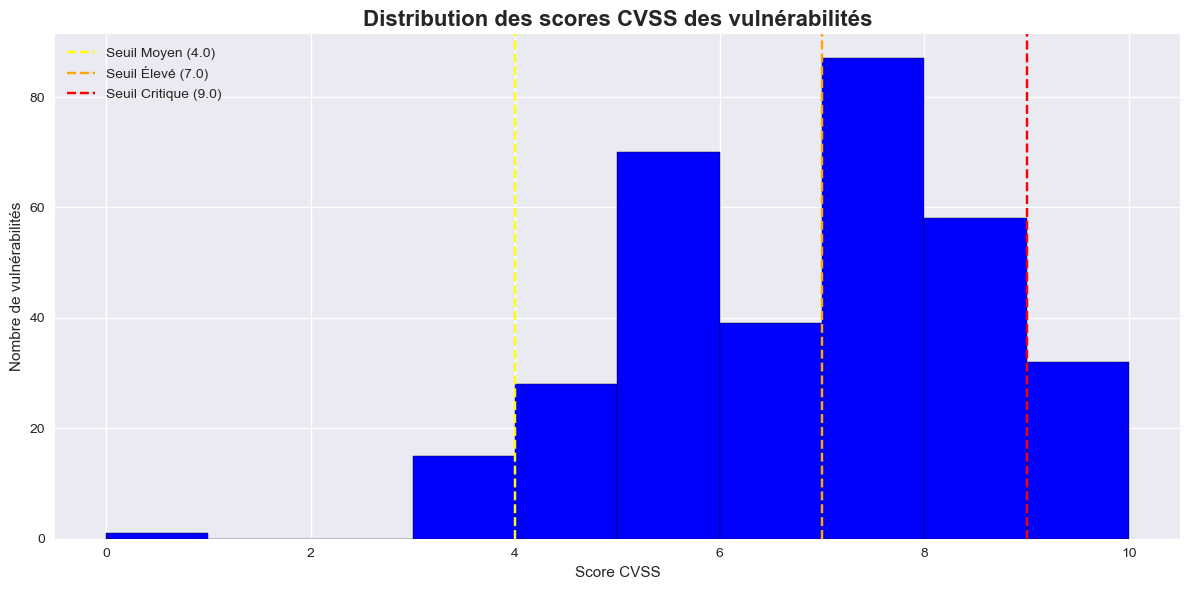

In [12]:
plt.figure(figsize=(12, 6))
plt.hist(df['cvss_score'], bins=10, color='blue', edgecolor='black')
plt.title("Distribution des scores CVSS des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)

plt.axvline(x=4.0, color='yellow', linestyle='--', label='Seuil Moyen (4.0)')
plt.axvline(x=7.0, color='orange', linestyle='--', label='Seuil Élevé (7.0)')
plt.axvline(x=9.0, color='red', linestyle='--', label='Seuil Critique (9.0)')
plt.legend()
plt.tight_layout()
plt.show()

## Historigramme des scores EPSS

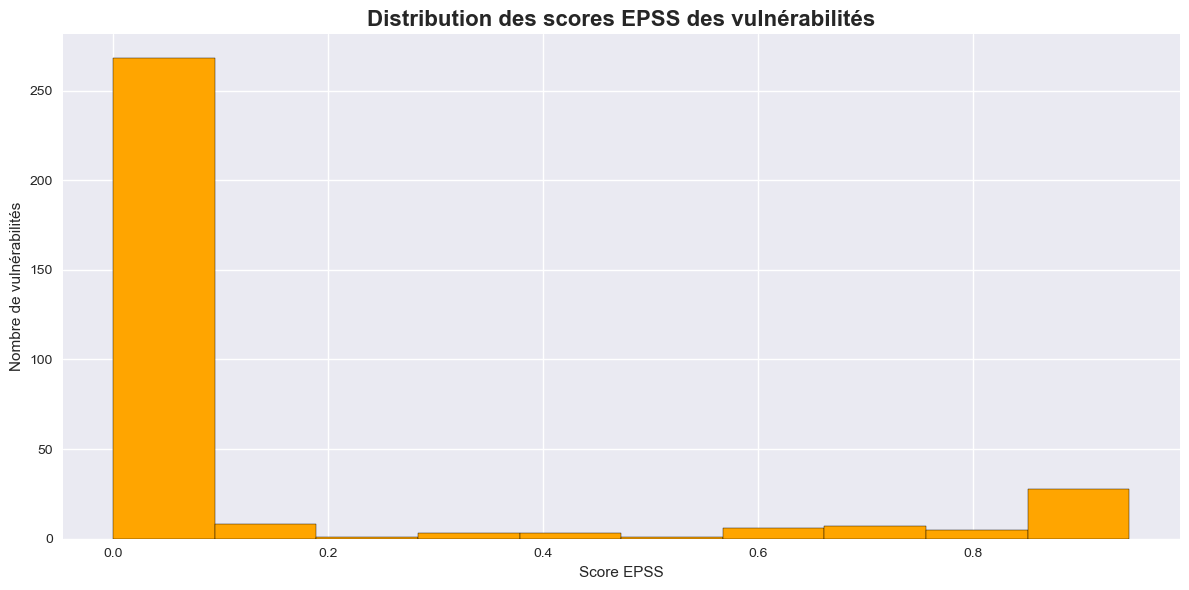

In [15]:
plt.figure(figsize=(12, 6))
plt.hist(df['epss_score'], bins=10, color='orange', edgecolor='black')
plt.title("Distribution des scores EPSS des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.tight_layout()
plt.show()

## Diagramme circulaire des types de vulnérabilités (CWE)

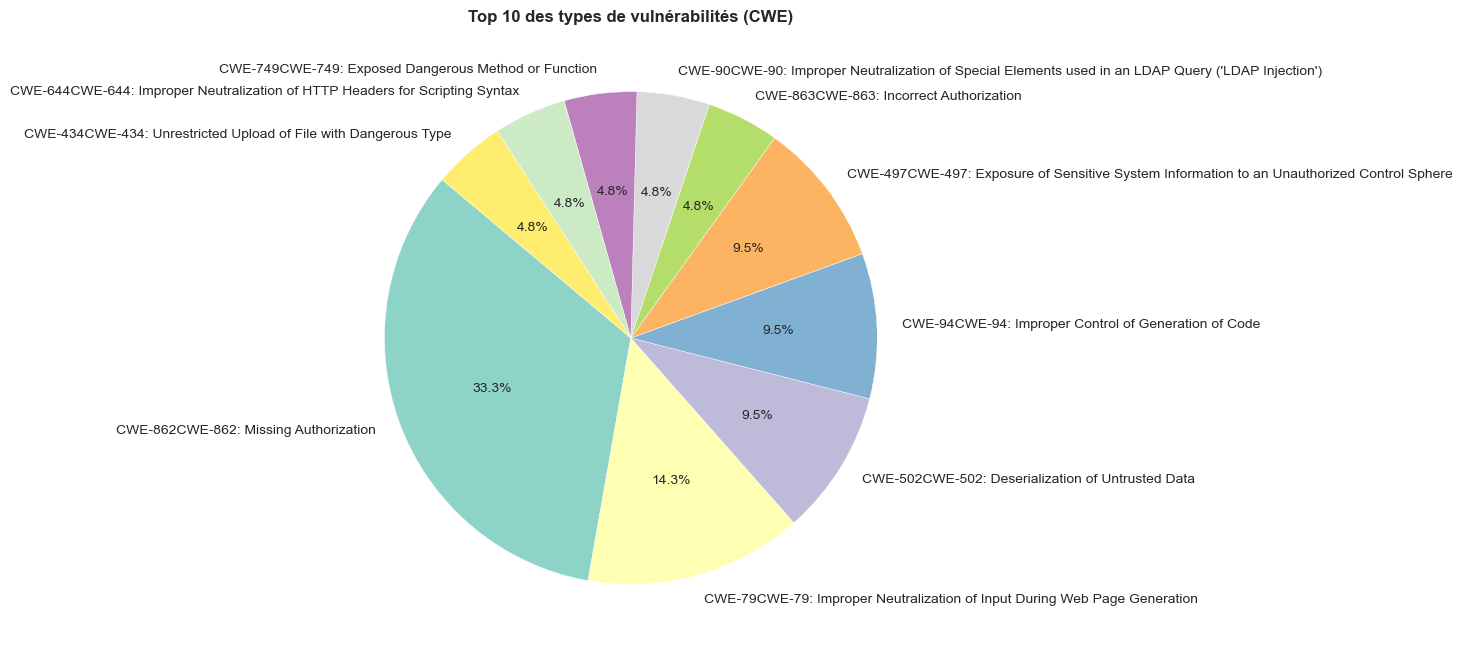

Répartition des CWE par rapport au dataset entier :
CWE-862: 7 (25.9%)
CWE-79: 3 (11.1%)
CWE-502: 2 (7.4%)
CWE-94: 2 (7.4%)
CWE-497: 2 (7.4%)
CWE-863: 1 (3.7%)
CWE-90: 1 (3.7%)
CWE-749: 1 (3.7%)
CWE-644: 1 (3.7%)
CWE-434: 1 (3.7%)


In [19]:
top_cwe_codes = df['type_cwe'].value_counts().nlargest(10).index
cwe_descriptions = df[df['type_cwe'].isin(top_cwe_codes)][['type_cwe', 'cwe_desc']].drop_duplicates().set_index('type_cwe')['cwe_desc']
cwe_counts = df['type_cwe'].value_counts().loc[top_cwe_codes]
labels = [f"{code}{cwe_descriptions.get(code, '')}" for code in top_cwe_codes]

plt.figure(figsize=(8, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(cwe_counts)))
plt.pie(cwe_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Top 10 des types de vulnérabilités (CWE)", fontweight='bold')
plt.show()

print("Répartition des CWE par rapport au dataset entier :")
for cwe, count in cwe_counts.items():
    percentage = (count / len(df[df['type_cwe'] != 'Non disponible'])) * 100
    print(f"{cwe}: {count} ({percentage:.1f}%)")


## Courbe des scores EPSS

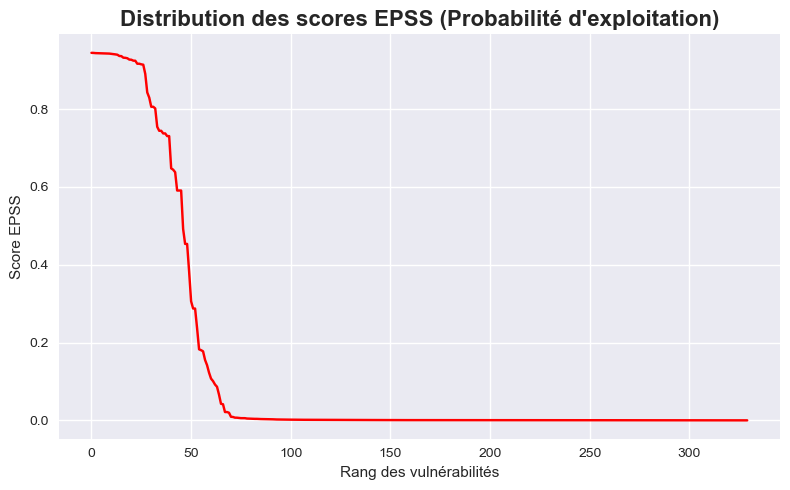

NameError: name 'df_with_epss' is not defined

In [25]:
plt.figure(figsize=(8, 5))
epss_sorted = df['epss_score'].sort_values(ascending=False)
plt.plot(range(len(epss_sorted)), epss_sorted, color='red')
plt.title('Distribution des scores EPSS (Probabilité d\'exploitation)', fontsize=16, fontweight='bold')
plt.xlabel('Rang des vulnérabilités')
plt.ylabel('Score EPSS')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the mean, ignoring NaN values
print(f"Score EPSS moyen: {df_with_epss['epss_score_numeric'].mean():.4f}")
print(f"Score EPSS médian: {df_with_epss['epss_score_numeric'].median():.4f}")
print(f"Score EPSS maximum: {df_with_epss['epss_score_numeric'].max():.4f}")

## Classement des produits/éditeurs les plus affectés

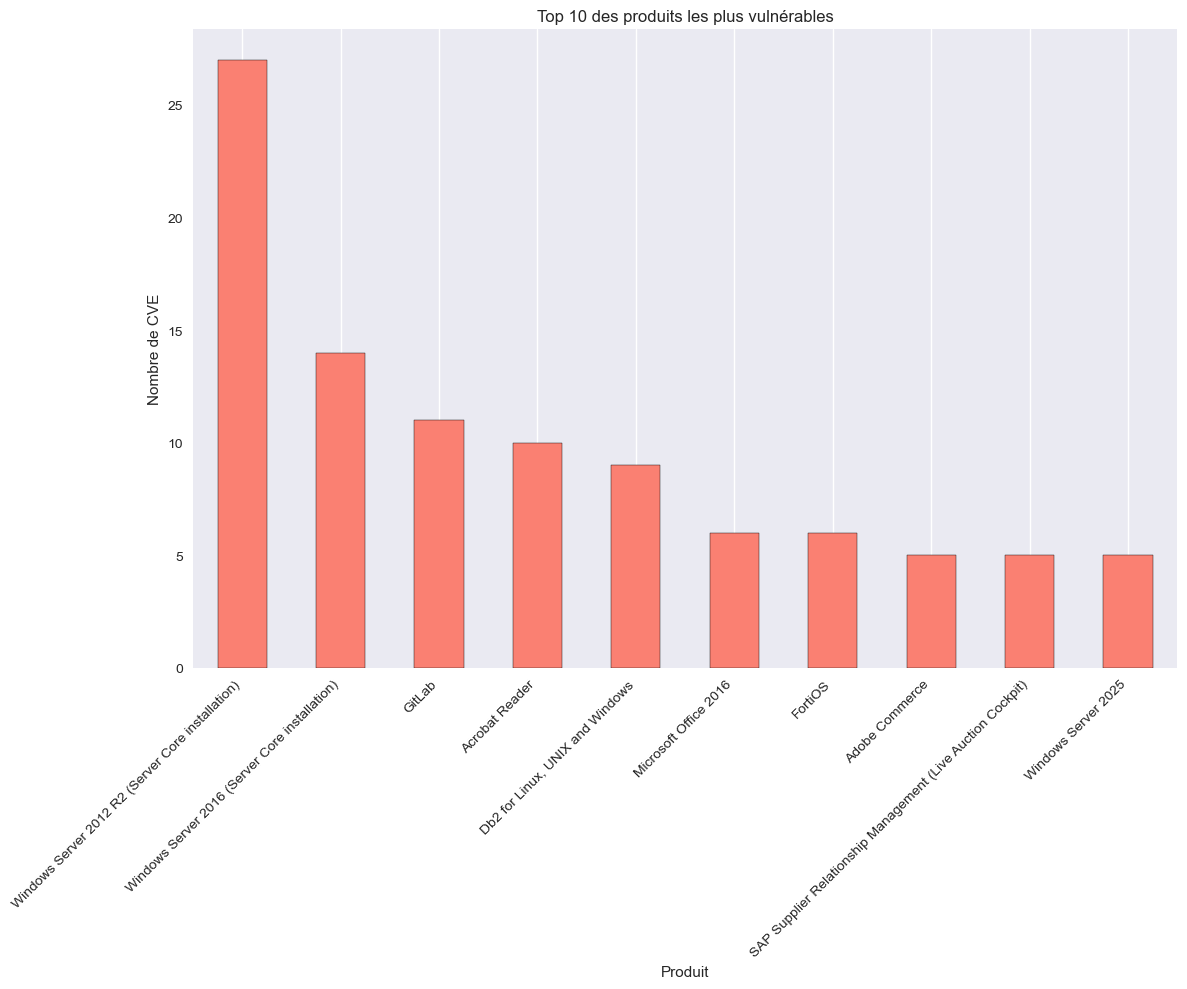

In [26]:
top_products = df['product'].value_counts().nlargest(10)
plt.figure(figsize=(12, 10))
top_products.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Top 10 des produits les plus vulnérables")
plt.xlabel("Produit")
plt.ylabel("Nombre de CVE")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Heatmap des corrélations entre CVSS et EPSS

In [27]:
# Création de catégories pour la heatmap
df_corr = df.dropna(subset=['cvss_score', 'epss_score']).copy()

# Catégorisation des scores
df_corr['cvss_category'] = pd.cut(df_corr['cvss_score'],
                                  bins=[0, 4, 7, 9, 10],
                                  labels=['Faible', 'Moyen', 'Élevé', 'Critique'])
df_corr['epss_category'] = pd.cut(df_corr['epss_score'],
                                  bins=[0, 0.1, 0.3, 0.7, 1],
                                  labels=['Très faible', 'Faible', 'Moyen', 'Élevé'])

# Création du tableau croisé
heatmap_data = pd.crosstab(df_corr['cvss_category'], df_corr['epss_category'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Nombre de vulnérabilités'})
plt.title('Corrélation entre niveaux CVSS et EPSS', fontsize=16, fontweight='bold')
plt.xlabel('Catégories EPSS (Probabilité d\'exploitation)')
plt.ylabel('Catégories CVSS (Gravité)')
plt.tight_layout()
plt.show()

NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

## Nuage de points entre score CVSS et score EPSS

In [ ]:
plt.figure(figsize=(8, 6))
colors = df['base_severity'].astype('category').cat.codes
plt.scatter(df['cvss_score'], df['epss_score'], c=colors, cmap='tab10')
plt.title("Relation entre CVSS et EPSS")
plt.xlabel("CVSS")
plt.ylabel("EPSS")
plt.grid(True)
plt.show()

# Calcul de la corrélation
correlation = df_corr['cvss_score'].corr(df_corr['epss_score'])
print(f"Coefficient de corrélation CVSS-EPSS: {correlation:.4f}")

## Courbe cumulative des vulnérabilités en fonction du temps

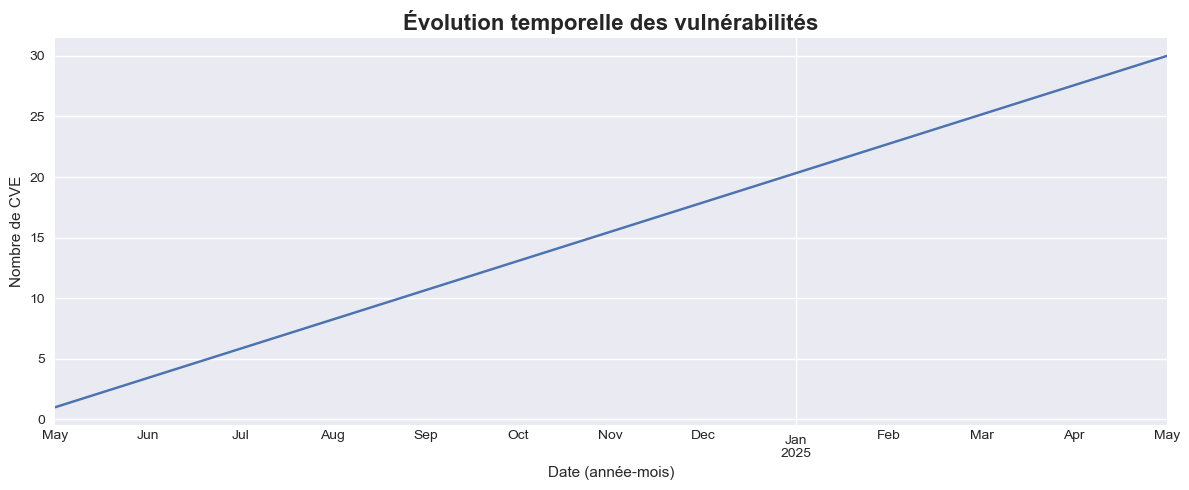

In [34]:
if pd.api.types.is_string_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
if pd.api.types.is_datetime64_any_dtype(df['date']):
    if hasattr(df['date'].dt, 'tz'):  # Only if timezone aware
        df['date'] = df['date'].dt.tz_localize(None)
df['year_month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size()
plt.figure(figsize=(12, 5))
monthly_counts.plot()
plt.title("Évolution temporelle des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de CVE")
plt.grid(True)
plt.tight_layout()
plt.show()

## Boxplot des scores CVSS par éditeur

<Figure size 1000x600 with 0 Axes>

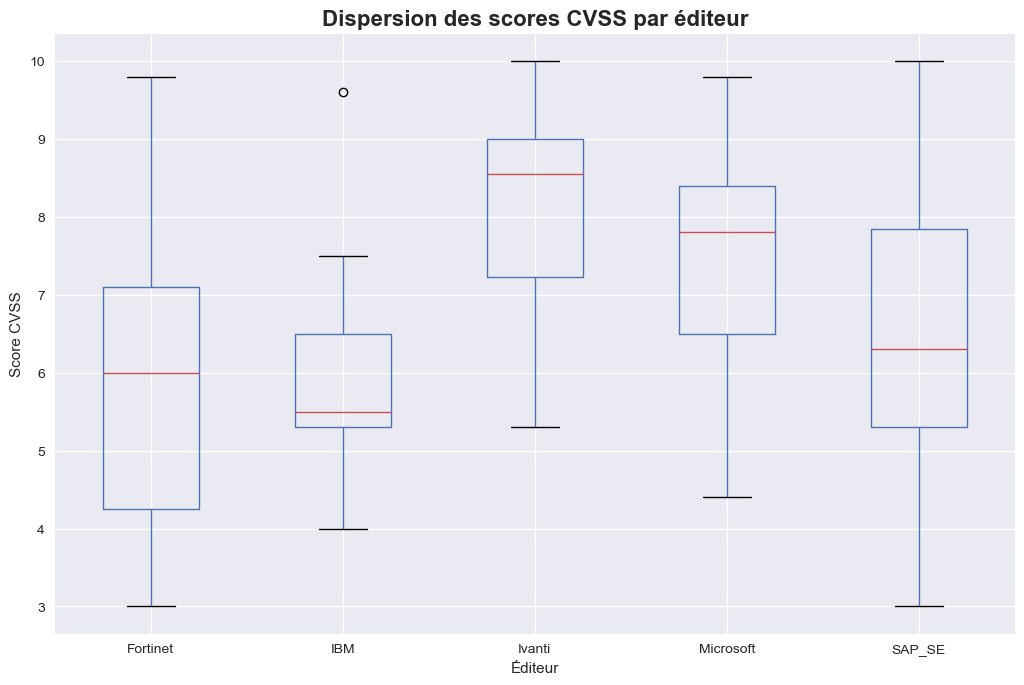

In [39]:
top_vendors = df['vendor'].value_counts().nlargest(5).index
top_vendor_df = df[df['vendor'].isin(top_vendors)]
plt.figure(figsize=(10, 6))
top_vendor_df.boxplot(column='cvss_score', by='vendor')
plt.title("Dispersion des scores CVSS par éditeur", fontsize=16, fontweight='bold')
plt.suptitle("")
plt.xlabel("Éditeur")
plt.ylabel("Score CVSS")
plt.grid(True)
plt.show()

# Etape 6 : Modèle de Machine Learning

## Normalisation

In [ ]:
features = df[['cvss_score', 'epss_score']]
target = df['base_severity']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_scaled[:5]

## Modèle supervisé

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

## Modèle non supervisé : KMeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

df['cluster'] = kmeans.labels_
print(df.head())